# Persiapan Lingkungan & Data

In [1]:
# --- Cell 1: Instalasi & Import Library ---
# Sel ini menginstal library tambahan (Optuna) dan mengimpor semua modul yang diperlukan.

# Instalasi library untuk Hyperparameter Tuning otomatis
!pip install optuna --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer  # Wajib untuk MICE
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Konfigurasi agar hasil konsisten (Reproducible)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
warnings.filterwarnings('ignore') # Matikan warning agar output bersih

# Deteksi GPU untuk MIDAS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Lingkungan siap. MIDAS akan berjalan pada: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 15.8 MB/s eta 0:00:00
Lingkungan siap. MIDAS akan berjalan pada: cuda


In [2]:
# --- Cell 2: Load Data & Preprocessing Awal ---
# Sel ini memuat dataset, memisahkan Target (y), dan melakukan Scaling pada Fitur (X).
# Scaling sangat penting agar Neural Network (MIDAS) dapat belajar dengan stabil.

# 1. Load Dataset
df = pd.read_csv('Dry_Bean.csv')

# 2. Pisahkan Fitur (X) dan Target (y)
X = df.drop(columns=['Class'])
y_ground_truth = df['Class'] # Simpan target asli

# 3. Scaling Data (MinMax 0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled_array = scaler.fit_transform(X)

# Kembalikan ke format DataFrame agar nama kolom tetap terjaga
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)

print(f"Data dimuat. Dimensi Fitur: {X_scaled.shape}")

Data dimuat. Dimensi Fitur: (13611, 16)


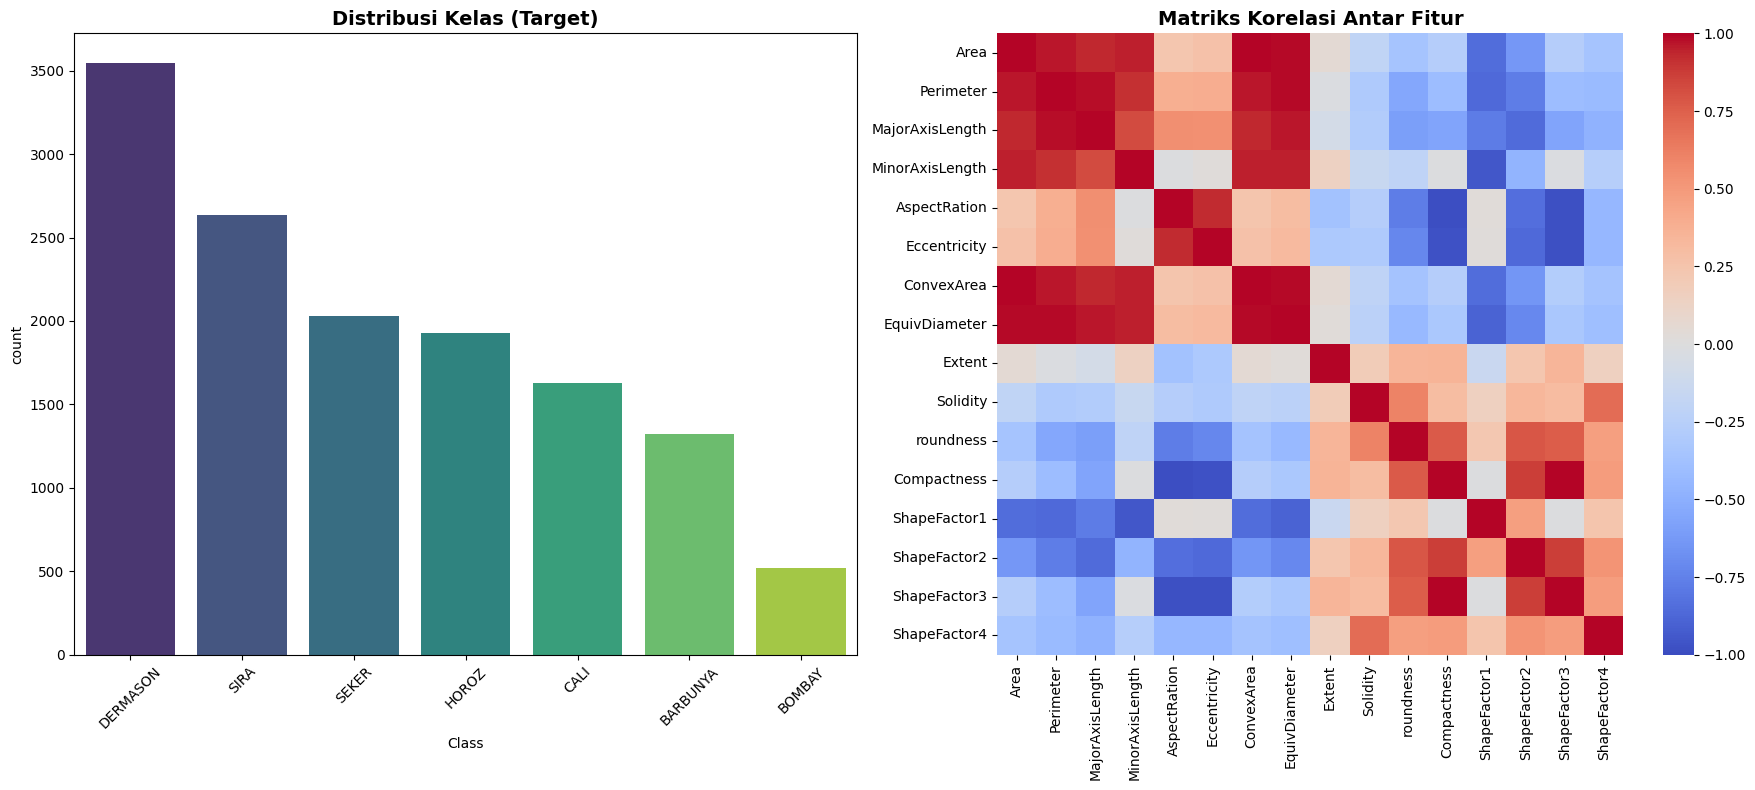

In [3]:
# --- Cell 3: Eksplorasi Data Awal (EDA) ---
# Sel ini menampilkan visualisasi dasar untuk memahami karakteristik data sebelum dirusak/imputasi.

plt.figure(figsize=(18, 8))

# Plot 1: Distribusi Target (Cek Imbalance)
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Class', palette='viridis', order=df['Class'].value_counts().index)
plt.title('Distribusi Kelas (Target)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

# Plot 2: Matriks Korelasi (Alasan penggunaan MICE/MIDAS)
plt.subplot(1, 2, 2)
# Korelasi antar fitur numerik
sns.heatmap(X_scaled.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriks Korelasi Antar Fitur', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Definisi Fungsi & Model (Inti Sistem)

In [4]:
# --- Cell 4: Fungsi Simulasi Missing Value (MCAR) ---
# Fungsi ini membuat lubang pada data secara acak (Missing Completely At Random).

def simulate_mcar(data, missing_rate, random_state=None):
    """
    Args:
        data: DataFrame lengkap (scaled).
        missing_rate: Persentase data yang akan dihapus (0.0 - 1.0).
    Returns:
        X_missing: DataFrame dengan NaN.
        mask: Matrix boolean (True = Data Hilang).
    """
    if random_state is not None:
        rng = np.random.RandomState(random_state)
    else:
        rng = np.random

    data_missing = data.copy()

    # Buat matrix random ukuran sama dengan data
    random_matrix = rng.rand(*data.shape)

    # Data dianggap hilang jika nilai random < rate
    mask = random_matrix < missing_rate

    # Set nilai menjadi NaN pada posisi mask
    data_missing[mask] = np.nan

    return data_missing, mask

In [5]:
# --- Cell 5: Arsitektur MIDAS (Autoencoder) ---
# Kelas ini mendefinisikan struktur Neural Network untuk metode MIDAS.

class MidasPyTorch(nn.Module):
    def __init__(self, input_dim, layer_structure=[256, 256, 256], input_drop=0.8, dropout_level=0.5):
        super(MidasPyTorch, self).__init__()

        # --- Encoder ---
        # Input Dropout tinggi berfungsi sebagai "Corruption" process
        self.input_dropout = nn.Dropout(p=1.0 - input_drop)

        self.enc_layer1 = nn.Linear(input_dim, layer_structure[0])
        self.enc_act1 = nn.ELU()
        self.enc_drop1 = nn.Dropout(p=dropout_level)

        self.enc_layer2 = nn.Linear(layer_structure[0], layer_structure[1])
        self.enc_act2 = nn.ELU()
        self.enc_drop2 = nn.Dropout(p=dropout_level)

        # --- Decoder ---
        self.dec_layer1 = nn.Linear(layer_structure[1], layer_structure[2])
        self.dec_act1 = nn.ELU()
        self.dec_drop1 = nn.Dropout(p=dropout_level)

        # Output Layer
        self.output_layer = nn.Linear(layer_structure[2], input_dim)
        self.output_act = nn.Sigmoid() # Sigmoid karena data kita MinMax Scaled (0-1)

    def forward(self, x):
        # Proses Denoising
        x_corrupt = self.input_dropout(x)

        # Encoding
        h1 = self.enc_drop1(self.enc_act1(self.enc_layer1(x_corrupt)))
        h2 = self.enc_drop2(self.enc_act2(self.enc_layer2(h1)))

        # Decoding
        h3 = self.dec_drop1(self.dec_act1(self.dec_layer1(h2)))
        out = self.output_act(self.output_layer(h3))

        return out

In [6]:
# --- Cell 6: Fungsi Helper Imputasi & Evaluasi RMSE ---
# Sel ini berisi fungsi pembungkus (wrapper) untuk menjalankan Mean, MICE, dan MIDAS,
# serta fungsi untuk menghitung RMSE hanya pada data yang hilang.

def calculate_rmse(ground_truth, imputed_data, mask):
    """Menghitung RMSE hanya pada lokasi data yang dimasking (hilang)."""
    gt = ground_truth.values if hasattr(ground_truth, 'values') else ground_truth
    imp = imputed_data.values if hasattr(imputed_data, 'values') else imputed_data
    m = mask.values if hasattr(mask, 'values') else mask

    # Hitung MSE hanya pada sel dimana mask == True
    mse = mean_squared_error(gt[m], imp[m])
    return np.sqrt(mse)

def run_mean_imputation(X_miss):
    """Strategi: Mengisi NaN dengan rata-rata kolom."""
    return X_miss.fillna(X_miss.mean())

def run_mice_imputation(X_miss, random_state=42):
    """Strategi: Multiple Imputation menggunakan Bayesian Ridge."""
    mice_imputer = IterativeImputer(estimator=BayesianRidge(),
                                    max_iter=20,
                                    random_state=random_state,
                                    tol=1e-3)
    X_mice_np = mice_imputer.fit_transform(X_miss)
    return pd.DataFrame(X_mice_np, columns=X_miss.columns)

def run_midas_imputation(X_miss, mask, epochs=50, lr=1e-4):
    """Strategi: Denoising Autoencoder (MIDAS) dengan Training Loop PyTorch."""

    # 1. Persiapan Data
    X_filled_temp = X_miss.fillna(0).values # Isi 0 sementara untuk input ke network

    # Konversi mask boolean ke float (1=Observed, 0=Missing untuk MIDAS)
    if hasattr(mask, 'values'):
        mask_val = (~mask.values).astype(float)
        mask_bool = mask.values
    else:
        mask_val = (~mask).astype(float)
        mask_bool = mask

    tensor_x = torch.tensor(X_filled_temp, dtype=torch.float32).to(device)
    tensor_m = torch.tensor(mask_val, dtype=torch.float32).to(device)

    dataset = TensorDataset(tensor_x, tensor_m)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # 2. Inisialisasi Model
    model = MidasPyTorch(input_dim=X_miss.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 3. Training Loop
    model.train()
    for epoch in range(epochs):
        for bx, bm in dataloader:
            optimizer.zero_grad()
            out = model(bx)
            # Loss Function: MSE hanya pada data yang Observed (bm=1)
            loss = ((out - bx)**2 * bm).sum() / (bm.sum() + 1e-9)
            loss.backward()
            optimizer.step()

    # 4. Prediksi & Imputasi
    model.eval()
    with torch.no_grad():
        full_pred = model(torch.tensor(X_filled_temp, dtype=torch.float32).to(device)).cpu().numpy()

        # Gabungkan: Ambil prediksi HANYA jika data aslinya missing
        X_miss_val = X_miss.values
        X_midas_numpy = np.where(mask_bool, full_pred, X_miss_val)
        X_midas_imp = pd.DataFrame(X_midas_numpy, columns=X_miss.columns)

    return X_midas_imp

# Eksperimen Imputasi (20%, 50%, 70%)

In [11]:
# --- Cell 7: Eksekusi Imputasi Multi-Skenario ---
# Sel ini menjalankan loop utama: Merusak data -> Imputasi dengan 3 metode -> Hitung RMSE.

SCENARIOS = [0.2, 0.5, 0.7]

# Dictionary untuk menyimpan hasil
imputation_results = {'Missing_Rate': [], 'Method': [], 'RMSE': []}
imputed_datasets = {} # Menyimpan DataFrame hasil imputasi untuk tahap klasifikasi

print("=== MEMULAI EKSPERIMEN IMPUTASI ===")

for rate in SCENARIOS:
    print(f"\n>> Memproses Missing Rate: {rate*100}%...")
    imputed_datasets[rate] = {}

    # 1. Simulasi Kerusakan Data
    X_miss, mask = simulate_mcar(X_scaled, rate, random_state=42)

    # 2. Metode Mean
    start = time.time()
    X_mean = run_mean_imputation(X_miss)
    rmse_mean = calculate_rmse(X_scaled, X_mean, mask)
    imputation_results['Missing_Rate'].append(f"{int(rate*100)}%")
    imputation_results['Method'].append('Mean')
    imputation_results['RMSE'].append(rmse_mean)
    imputed_datasets[rate]['Mean'] = X_mean
    print(f"   Mean  Done (RMSE: {rmse_mean:.4f}) - {time.time()-start:.2f}s")

    # 3. Metode MICE
    start = time.time()
    X_mice = run_mice_imputation(X_miss)
    rmse_mice = calculate_rmse(X_scaled, X_mice, mask)
    imputation_results['Missing_Rate'].append(f"{int(rate*100)}%")
    imputation_results['Method'].append('MICE')
    imputation_results['RMSE'].append(rmse_mice)
    imputed_datasets[rate]['MICE'] = X_mice
    print(f"   MICE  Done (RMSE: {rmse_mice:.4f}) - {time.time()-start:.2f}s")

    # 4. Metode MIDAS
    start = time.time()
    X_midas = run_midas_imputation(X_miss, mask, epochs=200)
    rmse_midas = calculate_rmse(X_scaled, X_midas, mask)
    imputation_results['Missing_Rate'].append(f"{int(rate*100)}%")
    imputation_results['Method'].append('MIDAS')
    imputation_results['RMSE'].append(rmse_midas)
    imputed_datasets[rate]['MIDAS'] = X_midas
    print(f"   MIDAS Done (RMSE: {rmse_midas:.4f}) - {time.time()-start:.2f}s")

print("\nEksperimen Imputasi Selesai.")

=== MEMULAI EKSPERIMEN IMPUTASI ===

>> Memproses Missing Rate: 20.0%...
   Mean  Done (RMSE: 0.1441) - 0.01s
   MICE  Done (RMSE: 0.0422) - 5.98s
   MIDAS Done (RMSE: 0.0751) - 368.69s

>> Memproses Missing Rate: 50.0%...
   Mean  Done (RMSE: 0.1446) - 0.01s
   MICE  Done (RMSE: 0.0598) - 0.65s
   MIDAS Done (RMSE: 0.0889) - 365.21s

>> Memproses Missing Rate: 70.0%...
   Mean  Done (RMSE: 0.1445) - 0.01s
   MICE  Done (RMSE: 0.0887) - 0.30s
   MIDAS Done (RMSE: 0.1055) - 362.64s

Eksperimen Imputasi Selesai.


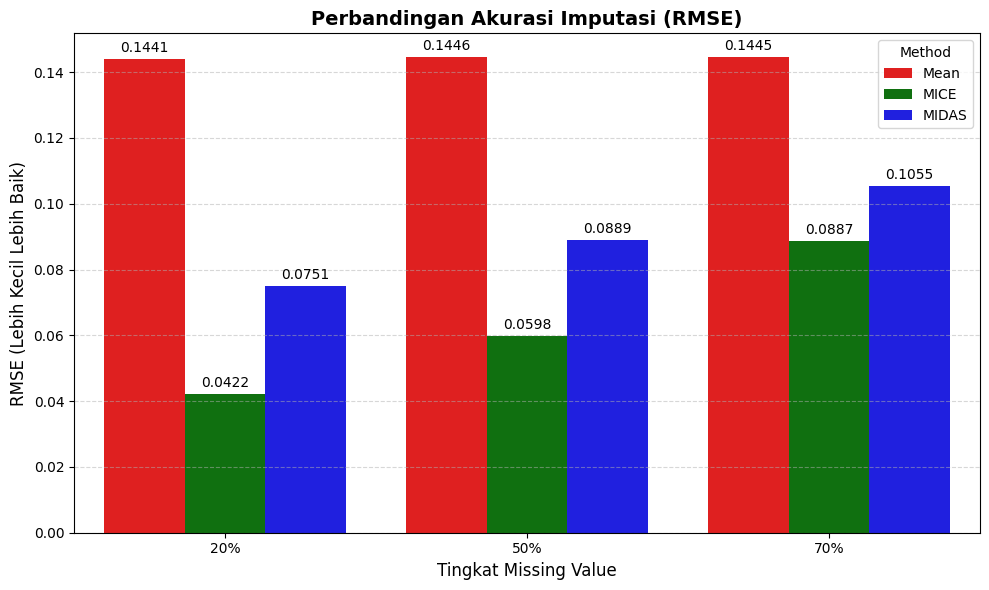

In [12]:
# --- Cell 8: Visualisasi Kualitas Imputasi (RMSE) ---
# Sel ini menampilkan perbandingan error (RMSE) dari ketiga metode.

df_imp_res = pd.DataFrame(imputation_results)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_imp_res, x='Missing_Rate', y='RMSE', hue='Method',
                 palette={'Mean': 'red', 'MICE': 'green', 'MIDAS': 'blue'})

plt.title('Perbandingan Akurasi Imputasi (RMSE)', fontsize=14, fontweight='bold')
plt.xlabel('Tingkat Missing Value', fontsize=12)
plt.ylabel('RMSE (Lebih Kecil Lebih Baik)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

# Evaluasi Klasifikasi (Turnamen Model)

In [13]:
# --- Cell 9: Setup Optuna & Fungsi Evaluasi Klasifikasi ---
# Sel ini berisi logika pencarian hyperparameter otomatis menggunakan Optuna.

optuna.logging.set_verbosity(optuna.logging.WARNING) # Supaya log tidak berisik

def get_model_from_trial(trial, model_name):
    """Mendefinisikan ruang pencarian (Search Space) untuk Optuna."""
    if model_name == 'SVM':
        c = trial.suggest_float('C', 0.1, 100.0, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
        return SVC(C=c, kernel=kernel, random_state=42)

    elif model_name == 'DT':
        depth = trial.suggest_int('max_depth', 5, 50)
        split = trial.suggest_int('min_samples_split', 2, 20)
        return DecisionTreeClassifier(max_depth=depth, min_samples_split=split, random_state=42)

    elif model_name == 'RF':
        n_est = trial.suggest_int('n_estimators', 10, 200)
        depth = trial.suggest_int('max_depth', 5, 50)
        return RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=42)

    elif model_name == 'KNN':
        k = trial.suggest_int('n_neighbors', 3, 20)
        weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
        return KNeighborsClassifier(n_neighbors=k, weights=weights)

    elif model_name == 'LR':
        c = trial.suggest_float('C', 0.01, 100.0, log=True)
        return LogisticRegression(C=c, solver='lbfgs', max_iter=1000, random_state=42)

def optimize_and_evaluate(X, y, model_name, n_trials=15):
    """Menjalankan optimasi Optuna dan mengembalikan skor terbaik."""

    # 1. Fungsi Objektif (Target yang mau dimaksimalkan)
    def objective(trial):
        model = get_model_from_trial(trial, model_name)
        # Cross Validation 3-Fold untuk estimasi yang robust
        scores = cross_val_score(model, X, y, cv=3, scoring='accuracy', n_jobs=-1)
        return scores.mean()

    # 2. Jalankan Studi
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # 3. Evaluasi Akhir menggunakan Parameter Terbaik
    # Split manual 80:20 untuk final score
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Rekonstruksi model terbaik
    from optuna.trial import FixedTrial
    best_model = get_model_from_trial(FixedTrial(study.best_params), model_name)

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')

def run_default_model(X, y, model_name):
    """Menjalankan model dengan parameter default."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if model_name == 'SVM': model = SVC(random_state=42)
    elif model_name == 'DT': model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'RF': model = RandomForestClassifier(random_state=42)
    elif model_name == 'KNN': model = KNeighborsClassifier()
    elif model_name == 'LR': model = LogisticRegression(max_iter=1000, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')

In [14]:
# --- Cell 10: Eksekusi Turnamen Klasifikasi ---
# Sel ini menjalankan loop besar untuk menguji semua kombinasi:
# Skenario Missing x Metode Imputasi x Jenis Model x (Default vs Tuned)

classification_results = {
    'Scenario': [], 'Imputation': [], 'Model': [],
    'Mode': [], 'Accuracy': [], 'F1_Score': []
}
MODELS_LIST = ['SVM', 'DT', 'RF', 'KNN', 'LR']
N_TRIALS = 15 # Budget Optuna per model

print(f"=== MEMULAI TURNAMEN KLASIFIKASI ({N_TRIALS} Trials/Model) ===")

# --- 1. Evaluasi Baseline (Data Bersih) ---
print("\n>> Evaluasi Baseline...")
for model in tqdm(MODELS_LIST, desc="Baseline"):
    # Default
    acc, f1 = run_default_model(X_scaled, y_ground_truth, model)
    classification_results['Scenario'].append('Baseline')
    classification_results['Imputation'].append('Original')
    classification_results['Model'].append(model)
    classification_results['Mode'].append('Default')
    classification_results['Accuracy'].append(acc)
    classification_results['F1_Score'].append(f1)

    # Tuned
    acc, f1 = optimize_and_evaluate(X_scaled, y_ground_truth, model, n_trials=N_TRIALS)
    classification_results['Scenario'].append('Baseline')
    classification_results['Imputation'].append('Original')
    classification_results['Model'].append(model)
    classification_results['Mode'].append('Tuned')
    classification_results['Accuracy'].append(acc)
    classification_results['F1_Score'].append(f1)

# --- 2. Evaluasi Data Imputasi ---
for rate in SCENARIOS:
    print(f"\n>> Evaluasi Skenario Missing Rate {rate*100}%...")

    # Loop Metode Imputasi
    for method_name, X_imp in imputed_datasets[rate].items():

        # Loop Model
        for model in tqdm(MODELS_LIST, desc=f"{method_name}"):
            # Default
            acc, f1 = run_default_model(X_imp, y_ground_truth, model)
            classification_results['Scenario'].append(f"{int(rate*100)}%")
            classification_results['Imputation'].append(method_name)
            classification_results['Model'].append(model)
            classification_results['Mode'].append('Default')
            classification_results['Accuracy'].append(acc)
            classification_results['F1_Score'].append(f1)

            # Tuned
            acc, f1 = optimize_and_evaluate(X_imp, y_ground_truth, model, n_trials=N_TRIALS)
            classification_results['Scenario'].append(f"{int(rate*100)}%")
            classification_results['Imputation'].append(method_name)
            classification_results['Model'].append(model)
            classification_results['Mode'].append('Tuned')
            classification_results['Accuracy'].append(acc)
            classification_results['F1_Score'].append(f1)

df_clf_results = pd.DataFrame(classification_results)
print("\nTurnamen Selesai.")

=== MEMULAI TURNAMEN KLASIFIKASI (15 Trials/Model) ===

>> Evaluasi Baseline...


Baseline: 100%|██████████| 5/5 [04:10<00:00, 50.02s/it]



>> Evaluasi Skenario Missing Rate 20.0%...


MIDAS: 100%|██████████| 5/5 [04:38<00:00, 55.77s/it]



>> Evaluasi Skenario Missing Rate 50.0%...


MIDAS: 100%|██████████| 5/5 [05:12<00:00, 62.42s/it]



>> Evaluasi Skenario Missing Rate 70.0%...


MIDAS: 100%|██████████| 5/5 [06:32<00:00, 78.59s/it]


Turnamen Selesai.


# Visualisasi Akhir & Kesimpulan

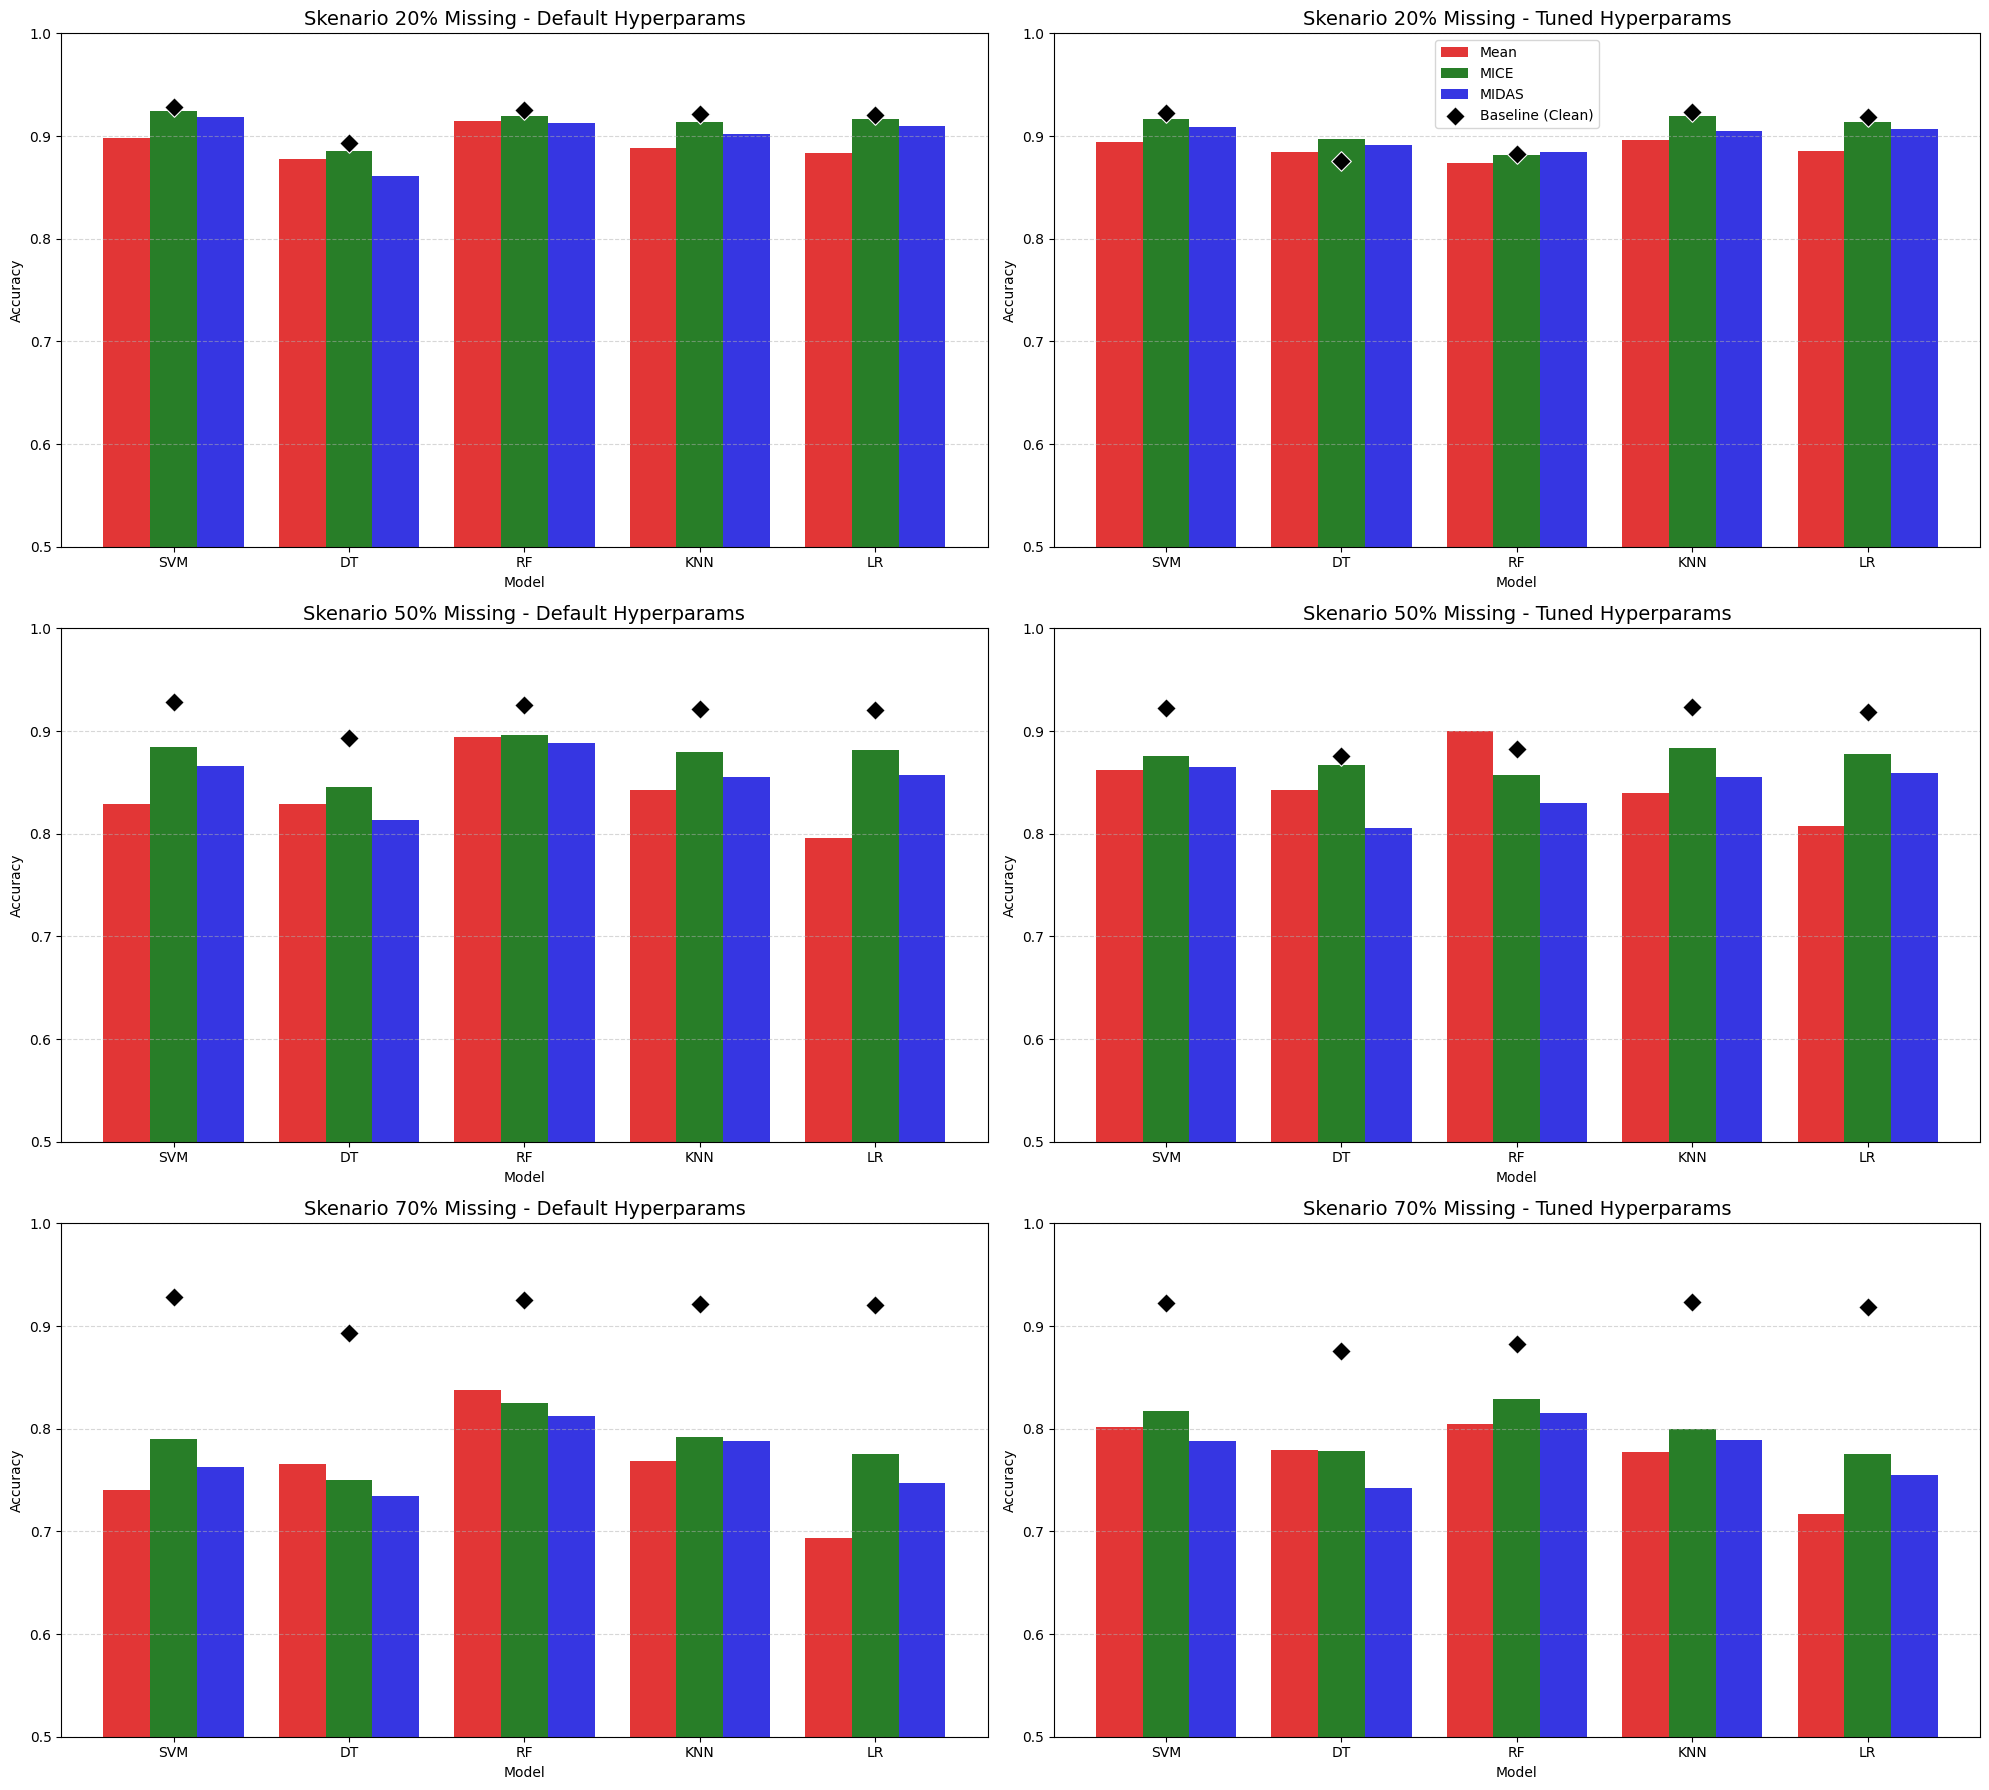

In [15]:
# --- Cell 11: Visualisasi Hasil Klasifikasi (Grid Plot) ---
# Sel ini membuat 6 grafik sekaligus untuk melihat dampak imputasi pada berbagai skenario.

def plot_classification_results(df_res):
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    scenarios_rate = ['20%', '50%', '70%']
    modes_list = ['Default', 'Tuned']

    # Ambil baseline rata-rata per mode sebagai garis referensi
    baseline_df = df_res[df_res['Scenario'] == 'Baseline']

    for i, rate in enumerate(scenarios_rate):
        for j, mode in enumerate(modes_list):
            ax = axes[i, j]

            # Filter Data
            subset = df_res[(df_res['Scenario'] == rate) & (df_res['Mode'] == mode)]
            base_subset = baseline_df[baseline_df['Mode'] == mode]

            # Bar Plot
            sns.barplot(data=subset, x='Model', y='Accuracy', hue='Imputation',
                        palette={'Mean': 'red', 'MICE': 'green', 'MIDAS': 'blue'},
                        ax=ax, alpha=0.9)

            # Scatter Baseline (Titik Hitam)
            sns.scatterplot(data=base_subset, x='Model', y='Accuracy',
                            color='black', marker='D', s=100, zorder=5,
                            label='Baseline (Clean)', ax=ax)

            ax.set_title(f'Skenario {rate} Missing - {mode} Hyperparams', fontsize=14)
            ax.set_ylim(0.5, 1.0)
            ax.grid(axis='y', linestyle='--', alpha=0.5)
            if not (i==0 and j==1): ax.legend().remove() # Legenda hanya di satu plot

    plt.tight_layout()
    plt.show()

plot_classification_results(df_clf_results)

     LAPORAN PEMENANG PER SKENARIO

>> Kategori Missing Rate 20%:
   Metode Imputasi : MICE
   Model Terbaik   : SVM
   Mode Tuning     : Default
   Akurasi         : 0.9240

>> Kategori Missing Rate 50%:
   Metode Imputasi : Mean
   Model Terbaik   : RF
   Mode Tuning     : Tuned
   Akurasi         : 0.8997

>> Kategori Missing Rate 70%:
   Metode Imputasi : Mean
   Model Terbaik   : RF
   Mode Tuning     : Default
   Akurasi         : 0.8377

           JUARA UMUM (GLOBAL)

METODE PALING SUPERIOR:
Skenario   : 20% Missing
Metode     : MICE
Model      : SVM
Mode       : Default
Akurasi    : 0.9240


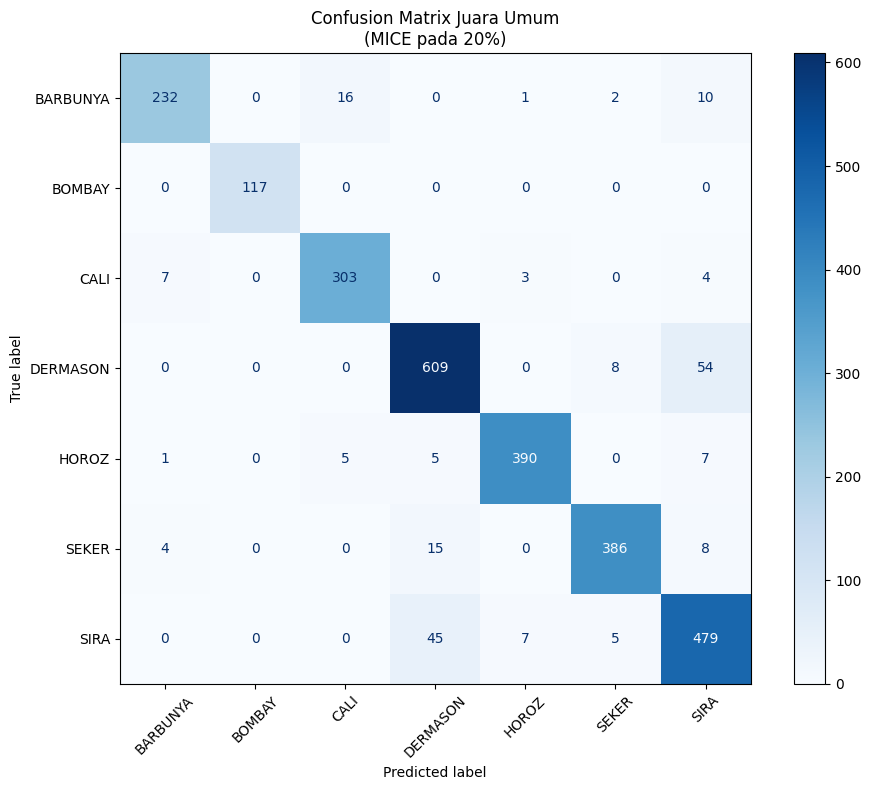

In [21]:
# --- Cell 12: Analisis Pemenang (Per Skenario & Juara Umum) ---
# Sel ini melakukan dua hal:
# 1. Melaporkan metode & model terbaik untuk setiap tingkat kerusakan data (20%, 50%, 70%).
# 2. Memilih satu Juara Umum untuk divisualisasikan Confusion Matrix-nya.

# Filter: Kita hanya fokus pada data Imputasi (Baseline tidak ikut kompetisi)
df_imputed_only = df_clf_results[df_clf_results['Scenario'] != 'Baseline']
target_scenarios = ['20%', '50%', '70%']

print("="*40)
print("     LAPORAN PEMENANG PER SKENARIO")
print("="*40)

# --- BAGIAN A: Loop Mencari Pemenang per Skenario ---
for rate in target_scenarios:
    # Ambil data hanya untuk skenario tersebut (misal hanya 20%)
    subset = df_imputed_only[df_imputed_only['Scenario'] == rate]

    if not subset.empty:
        # Cari akurasi tertinggi di subset ini
        best_idx_sub = subset['Accuracy'].idxmax()
        best_row_sub = subset.loc[best_idx_sub]

        print(f"\n>> Kategori Missing Rate {rate}:")
        print(f"   Metode Imputasi : {best_row_sub['Imputation']}")
        print(f"   Model Terbaik   : {best_row_sub['Model']}")
        print(f"   Mode Tuning     : {best_row_sub['Mode']}")
        print(f"   Akurasi         : {best_row_sub['Accuracy']:.4f}")
    else:
        print(f"\n>> Kategori {rate}: Data tidak ditemukan.")

print("\n" + "="*40)
print("           JUARA UMUM (GLOBAL)")
print("="*40)

# --- BAGIAN B: Mencari Juara Umum (Tertinggi dari Semuanya) ---
best_row_idx = df_imputed_only['Accuracy'].idxmax()
best_row = df_imputed_only.loc[best_row_idx]

print(f"\nMETODE PALING SUPERIOR:")
print(f"Skenario   : {best_row['Scenario']} Missing")
print(f"Metode     : {best_row['Imputation']}")
print(f"Model      : {best_row['Model']}")
print(f"Mode       : {best_row['Mode']}")
print(f"Akurasi    : {best_row['Accuracy']:.4f}")

# --- BAGIAN C: Visualisasi Confusion Matrix Juara Umum ---
# 1. Ambil Data
rate_float = float(best_row['Scenario'].strip('%')) / 100
X_final = imputed_datasets[rate_float][best_row['Imputation']]

# 2. Split Ulang
X_train, X_test, y_train, y_test = train_test_split(X_final, y_ground_truth, test_size=0.2, random_state=42)

# 3. Re-train Model Juara
if best_row['Model'] == 'RF': clf = RandomForestClassifier(random_state=42)
elif best_row['Model'] == 'SVM': clf = SVC(random_state=42)
elif best_row['Model'] == 'KNN': clf = KNeighborsClassifier()
elif best_row['Model'] == 'DT': clf = DecisionTreeClassifier(random_state=42)
elif best_row['Model'] == 'LR': clf = LogisticRegression(max_iter=1000, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 4. Plot
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', values_format='d', xticks_rotation=45, ax=plt.gca())
plt.title(f"Confusion Matrix Juara Umum\n({best_row['Imputation']} pada {best_row['Scenario']})")
plt.grid(False)
plt.tight_layout()
plt.show()

In [18]:
# --- Cell 13: Simpan Hasil ---
# Menyimpan tabel hasil eksperimen ke CSV untuk keperluan laporan.
df_clf_results.to_csv('Hasil_Lengkap_Imputasi_Klasifikasi.csv', index=False)
print("File 'Hasil_Lengkap_Imputasi_Klasifikasi.csv' berhasil disimpan.")

File 'Hasil_Lengkap_Imputasi_Klasifikasi.csv' berhasil disimpan.
